# Permutation Feature Importance

In [42]:
# !pip install scikit-learn==1.0.1

In [5]:
import sklearn

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [6]:
print(f'The scikit-learn version is {sklearn.__version__}.')
print(f'The tensorflow version is {tf.__version__}.')

The scikit-learn version is 1.2.1.
The tensorflow version is 2.11.0.


### Load the dataset

In [7]:
cal_housing = fetch_california_housing()

Get a summary description of the dataset

In [8]:
print(cal_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [9]:
X = cal_housing.data
y = cal_housing.target
cal_features = cal_housing.feature_names

df = pd.concat((pd.DataFrame(X, columns=cal_features),
                pd.DataFrame({'MedianHouseVal': y})), axis=1)

In [10]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Train a model in tensorflow

In [11]:
# helper functions to normalize the feature array and compute MSE
def normalize(np_array):
    array_mean = np.mean(np_array, axis=0)
    array_std = np.std(np_array, axis=0)
    return (np_array - array_mean) / array_std

def compute_mse(preds, labels):
    return np.mean((preds - labels)**2)

In [12]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(40, activation=tf.nn.relu, input_shape=[len(X_train[0])]),
        tf.keras.layers.Dense(20, activation=tf.nn.relu),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

In [13]:
# Create dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
model = build_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(normalize(X_train), y_train, epochs=100, verbose=0,
                    validation_data = (normalize(X_test), y_test),
                    callbacks=[early_stopping]
                   )

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

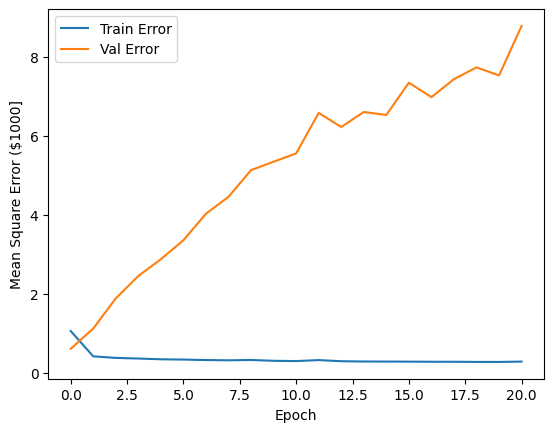

In [15]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error ($1000]')
    plt.plot(history['epoch'], history['mse'], label='Train Error')
    plt.plot(history['epoch'], history['val_mse'], label = 'Val Error')
    plt.legend()

plot_history(hist)

In [16]:
test_preds = np.squeeze(model.predict(normalize(X_test)))
mse_test = compute_mse(test_preds, y_test)
print(f'The RMSE for our TF model is {np.sqrt(mse_test)}')

129/129 [==============================] - 0s 1ms/step
The RMSE for our TF model is 2.9646795725431248


Perturb features values in the test set.

In [17]:
df_test = pd.DataFrame(X_test, columns=cal_features)

In [18]:
df_perturb = df_test.copy()
df_perturb['MedInc'] = df_perturb['MedInc'].sample(frac=1.0).values

In [19]:
df_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.5045,43.0,4.589681,1.120393,1061.0,2.606880,37.82,-122.27
1,2.4667,33.0,4.432548,1.004283,1851.0,3.963597,33.98,-117.36
2,1.4767,16.0,5.504983,1.295681,572.0,1.900332,38.93,-122.60
3,4.0791,11.0,5.878902,1.098493,4773.0,2.568891,33.17,-117.33
4,1.6635,37.0,4.990196,1.044118,663.0,3.250000,36.51,-119.56


In [20]:
df_perturb.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,5.3991,43.0,4.589681,1.120393,1061.0,2.606880,37.82,-122.27
1,3.5000,33.0,4.432548,1.004283,1851.0,3.963597,33.98,-117.36
2,7.8521,16.0,5.504983,1.295681,572.0,1.900332,38.93,-122.60
3,1.6435,11.0,5.878902,1.098493,4773.0,2.568891,33.17,-117.33
4,4.8250,37.0,4.990196,1.044118,663.0,3.250000,36.51,-119.56


Compute the MSE on the test set with 'MedInc' perturbed.

In [21]:
test_preds = np.squeeze(model.predict(normalize(df_perturb.values)))
mse_test = compute_mse(test_preds, y_test)
print(f'The RMSE for our TF model with MedInc shuffled is {np.sqrt(mse_test)}')

129/129 [==============================] - 0s 2ms/step
The RMSE for our TF model with MedInc shuffled is 3.039349428001002


Compute the score for each feature value:

In [22]:
result = []

for feature in cal_features:
    df_perturb = df_test.copy()
    # shuffle feature values
    df_perturb[feature] = df_perturb[feature].sample(frac=1.0).values
    
    test_preds = np.squeeze(model.predict(normalize(df_perturb.values)))
    mse_perturb = compute_mse(test_preds, y_test)
    result.append({'feature': feature,
                   'score': mse_perturb - mse_test})

df_pfi = pd.DataFrame(result).sort_values(by='score',
                                          ascending=False)
df_pfi

129/129 [==============================] - 0s 1ms/step


,feature,score
5,AveOccup,1.139744
6,Latitude,1.090732
0,MedInc,0.109821
3,AveBedrms,-0.315165
2,AveRooms,-0.405106
1,HouseAge,-0.503221
4,Population,-0.518736
7,Longitude,-0.756071


Of course, in practice you'd want to repeat this multiple times to get a statistically significant measure. For that, we'll use sk-learn.

## Permutation Feature Importance in Scikit-learn

In [24]:
df_train = pd.DataFrame(X_train, columns=cal_features)
df_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,3.9423,39.0,5.509653,1.183398,1338.0,2.583012,37.15,-122.13
1,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
2,2.3667,11.0,4.559603,1.097682,1328.0,2.198675,36.83,-119.78
3,1.3417,33.0,4.421801,1.037915,838.0,3.971564,34.12,-117.33
4,5.3920,52.0,6.870536,0.946429,535.0,2.388393,32.75,-117.18


In [25]:
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Create models
mlp_reg = MLPRegressor(hidden_layer_sizes=[30, 20, 10, 5],
                       max_iter=700)

# Create pipeline
transformer = ColumnTransformer([
    ('numerical', MinMaxScaler(feature_range=(-1,1)), cal_features),
])

mlp_pipeline = Pipeline(steps=[
    ('transform', transformer),
    ('model', mlp_reg)
])


mlp_pipeline.fit(df_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numerical',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude',
                                                   'Longitude'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=[30, 20, 10, 5],
                              max_iter=700))])

In [26]:
df_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.5045,43.0,4.589681,1.120393,1061.0,2.606880,37.82,-122.27
1,2.4667,33.0,4.432548,1.004283,1851.0,3.963597,33.98,-117.36
2,1.4767,16.0,5.504983,1.295681,572.0,1.900332,38.93,-122.60
3,4.0791,11.0,5.878902,1.098493,4773.0,2.568891,33.17,-117.33
4,1.6635,37.0,4.990196,1.044118,663.0,3.250000,36.51,-119.56


In [27]:
model_mse_error = compute_mse(mlp_pipeline.predict(df_test), y_test)

print(f'Mean squared error of MLP model: {model_mse_error}')

Mean squared error of MLP model: 1.3895330245396686


In [33]:
mlp_pipeline.score(df_test, y_test)

-0.001551162183757393

In [34]:
from sklearn.inspection import permutation_importance
result = permutation_importance(estimator=mlp_pipeline,
                                X=df_test,
                                y=y_test,
                                n_repeats=30)

In [35]:
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [36]:
result.importances_mean

array([-2.07288923e-06,  1.81615113e-06,  4.45143652e-06,  4.45143652e-06,
       -7.94013792e-07,  3.35448812e-08, -2.30287895e-06,  2.93916154e-06])

In [38]:
for i in result.importances_mean.argsort()[::-1]:
    print(f'{cal_features[i]}: \t'
          f'{result.importances_mean[i]:.8f} +/- {result.importances_std[i]:.3f}')

AveBedrms: 	0.00000445 +/- 0.000
AveRooms: 	0.00000445 +/- 0.000
Longitude: 	0.00000294 +/- 0.000
HouseAge: 	0.00000182 +/- 0.000
AveOccup: 	0.00000003 +/- 0.000
Population: 	-0.00000079 +/- 0.000
MedInc: 	-0.00000207 +/- 0.000
Latitude: 	-0.00000230 +/- 0.000


Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License